In [1]:
import sys
sys.path.append("..")

In [45]:
import os

In [2]:
import cv2

In [3]:
import numpy as np

In [4]:
import dlib
from pathlib import Path

In [5]:
import torch

In [100]:
rho=None
theta=None

In [102]:
assert rho and theta, 'ciao'

AssertionError: ciao

In [6]:
from model_linear_2d import Generator as Generator_l2
from model_gaussian_2d import Generator as Generator_g2

In [119]:
G = GANmut(G_path='../models/gaus_2d/1800000-G.ckpt',model='gaussian')

Device: cuda


In [194]:
class GANmut:

    def __init__(self, G_path,model='linear', g_conv_dim=64, c_dim=7, g_repeat_num=6):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Device:", self.device)
        self.model = model
        
        if self.model=='linear':
            self.G= Generator_l2(self.device, g_conv_dim , c_dim, g_repeat_num)

        
        elif self.model=='gaussian':
            self.G= Generator_g2(self.device, g_conv_dim , c_dim, g_repeat_num)
            
            
        else:
            raise ValueError("choose either model='linear' or model='gaussian'")
            
        self.G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
        self.G.to(self.device)
        self.detector = dlib.get_frontal_face_detector()
        

    def emotion_edit(self, img_path, x=None,y=None, theta=None, rho=None, save=False):
                     
        if self.model=='linear':
            assert (rho is not None) or (theta is not None),'if model is linear you must provide rho and theta'
        else:
            assert (x is not None) and (y is not None), 'if model is gaussian you must provide x and y'
                     
                     
            
                     
        img = cv2.imread(img_path, 1)  # BGR
        img_rgb = img[:, :, [2, 1, 0]]
        plt.title('Original Image')
        plt.imshow(img_rgb)

        # extract face
        det = self.detector(img, 1)[0]
        (xx, yy, w, h) = rect_to_bb(det)
        face = cv2.resize(img[yy:yy + h, xx:xx + w], (128, 128))
        
        plt.figure()
        plt.title('Detected face')
        plt.imshow(face[:, :, [2, 1, 0]])

        # adapt image format for G
        face = face.transpose((2, 0, 1))  # [H,W,C] --> [C,H,W]
        face = (face / 255.0 - 0.5) / 0.5  # normalize to [-1, 1]
        face = torch.from_numpy(face).float().unsqueeze(0).to(self.device)

        # edit emotion
        
        with torch.no_grad():
                     
            if self.model=='linear':
                mode = 'manual_selection'
                expr = (torch.tensor([np.cos(theta), np.sin(theta)]) * rho).to(self.device).float()
                face_g = self.G(face, None, None, mode=mode, manual_expr=expr)[0][0, [2, 1, 0], :, :] / 2 + 0.5
            else:
                expr=torch.Tensor([x,y]).unsqueeze(0).to(self.device)
                face_g= self.G(face,expr)[0][0,[2,1,0],:,:]/2+0.5
                
                     
        
       
            
        face_g = face_g.transpose(0, 2).transpose(0, 1).detach().cpu().numpy()
        
        plt.figure()
        plt.title('Edited face')
        plt.imshow(face_g)

        # insert edited face in original image
        img_rgb[yy:yy + h, xx:xx + w] = cv2.resize(face_g, (h, w)) * 255

        plt.figure()
        plt.title('Edited image')
        plt.imshow(img_rgb)

        if save:
            save_dir = "../edited_images"
            Path(save_dir).mkdir(parents=True, exist_ok=True)
            img_name = f'theta_{theta}_rho_{rho}' + os.path.split(img_path)[-1]
            img_name = os.path.join(save_dir, img_name)
            plt.imsave(img_name, img_rgb)
            

In [195]:
G = GANmut(G_path='../models/gaus_2d/1800000-G.ckpt',model='gaussian')

Device: cuda


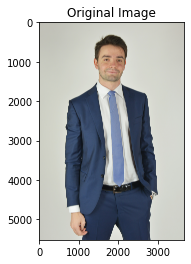

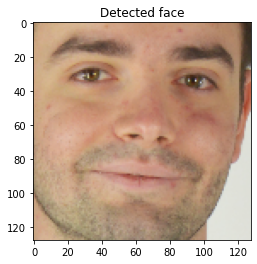

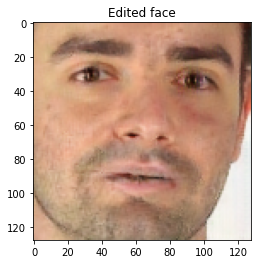

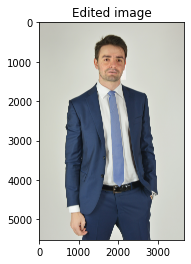

In [197]:
G.emotion_edit(img_path='../images/img1.jpg', x = 0.1, y = -0.5, save = True )

In [179]:
G = GANmut(G_path='../models/lin_2d/1000000-G.ckpt',model='linear')


Device: cuda


In [175]:
angle=np.pi
strength=0.3

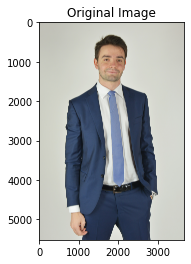

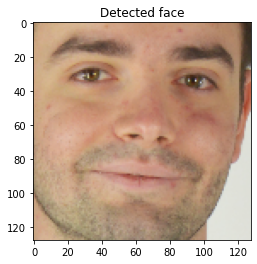

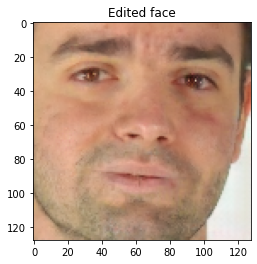

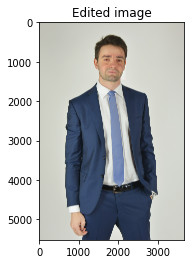

In [176]:
G.emotion_edit(img_path='../images/img1.jpg', theta=angle, rho = strength, save = True )

In [43]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [ ]:
class GANmut:

    def __init__(self, G_path,model='linear', g_conv_dim=64, c_dim=7, g_repeat_num=6):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Device:", self.device)
        self.model = model
        
        if self.model=='linear':
            self.G= Generator_l2(self.device, g_conv_dim , c_dim, g_repeat_num)
        
        elif self.model=='gaussian':
            self.G= Generator_g2(self.device, g_conv_dim , c_dim, g_repeat_num)
            
        else:
            raise ValueError("choose either model='linear' or model='gaussian'")
            
        
        self.G.to(self.device)
        self.detector = dlib.get_frontal_face_detector()

    def emotion_edit(self, img_path, x=None,y=None, theta=None, rho=None, save=False):
                     
        if self.model=='linear':
            assert rho and theta,'if model is linear you must provide rho and theta'
        else:
            assert x and y, 'if model is gaussian you must provide x and y'
                     
                     
            
                     
        img = cv2.imread(img_path, 1)  # BGR
        img_rgb = img[:, :, [2, 1, 0]]
        plt.title('Original Image')
        plt.imshow(img_rgb)

        # extract face
        det = self.detector(img, 1)[0]
        (x, y, w, h) = rect_to_bb(det)
        face = cv2.resize(img[y:y + h, x:x + w], (128, 128))
        
        plt.figure()
        plt.title('Detected face')
        plt.imshow(face[:, :, [2, 1, 0]])

        # adapt image format for G
        face = face.transpose((2, 0, 1))  # [H,W,C] --> [C,H,W]
        face = (face / 255.0 - 0.5) / 0.5  # normalize to [-1, 1]
        face = torch.from_numpy(face).float().unsqueeze(0).to(self.device)

        # edit emotion
        
        with torch.no_grad():
                     
            if self.model=='linear':
                mode = 'manual_selection'
                expr = (torch.tensor([np.cos(theta), np.sin(theta)]) * rho).to(self.device).float()
                face_g = self.G(face, None, None, mode=mode, manual_expr=expr)[0][0, [2, 1, 0], :, :] / 2 + 0.5
            else:
                expr=torch.Tensor([x,y]).unsqueeze(0)
                img= self.G(face,expr)[0][0,[2,1,0],:,:]/2+0.5
                
                     
        
       
            
        face_g = face_g.transpose(0, 2).transpose(0, 1).detach().cpu().numpy()
        
        plt.figure()
        plt.title('Edited face')
        plt.imshow(face_g)

        # insert edited face in original image
        img_rgb[y:y + h, x:x + w] = cv2.resize(face_g, (h, w)) * 255

        plt.figure()
        plt.title('Edited image')
        plt.imshow(img_rgb)

        if save:
            save_dir = "../edited_images"
            Path(save_dir).mkdir(parents=True, exist_ok=True)
            img_name = f'theta_{theta}_rho_{rho}' + os.path.split(img_path)[-1]
            img_name = os.path.join(save_dir, img_name)
            plt.imsave(img_name, img_rgb)
            

In [8]:
G_path_l2='../models/lin_2d/1000000-G.ckpt'
G_path_g2='../models/gaus_2d/1800000-G.ckpt'

In [9]:
g_conv_dim=64
c_dim=7
g_repeat_num=6
G_l2 = Generator_l2(device,g_conv_dim,c_dim,g_repeat_num)
G_l2.load_state_dict(torch.load(G_path_l2, map_location=lambda storage, loc: storage))
G_l2.to(device)
#G_l2.eval()

Generator(
  (axes): Linear(in_features=2, out_features=6, bias=True)
  (main): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3)

In [33]:
image = cv2.imread('../images/img1.jpg')

In [19]:
import matplotlib.pyplot as plt

In [11]:
detector = dlib.get_frontal_face_detector()

dets = detector(image, 1)

NameError: name 'image' is not defined

In [25]:
from imutils.face_utils import rect_to_bb

In [14]:
for det in dets:
    (x, y, w, h) = rect_to_bb(det)

In [15]:
cropped=cv2.resize(image[y:y+h,x:x+w,],dsize=(128,128))

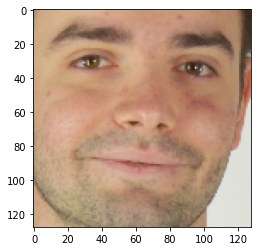

In [16]:
imgplot = plt.imshow(cropped[:,:,[2,1,0]])

In [45]:
angle=(2*np.pi)/7
strength=0.8
img_path='../images/img1.jpg'
img = cv2.imread(img_path, 1)  # BGR
dets = detector(img, 1)
for det in dets:
    (x, y, w, h) = rect_to_bb(det)
img = cv2.resize(img[y:y+h,x:x+w], (128, 128))
img = img.transpose((2, 0, 1))  # [H,W,C] --> [C,H,W]
img = (img / 255.0 - 0.5) / 0.5  # normalize to [-1, 1]
print(img.min())
print(img.max())
img = torch.from_numpy(img).float().unsqueeze(0).to(device)
expr=(torch.tensor([np.cos(angle),np.sin(angle)])*strength).to(device,dtype=torch.float)
img=G_l2(img,None,None,mode='manual_selection',manual_expr=expr)[0][0,[2,1,0],:,:]/2+0.5
img=img.detach().cpu().numpy().transpose(1,2,0)



-0.8588235294117648
0.8352941176470587


In [19]:
img_path='../images/img1.jpg'
img = cv2.imread(img_path, 1)  # BGR
dets = detector(img, 1)
for det in dets:
    (x, y, w, h) = rect_to_bb(det)
img = cv2.resize(img[y:y+h,x:x+w], (128, 128))
img = img.transpose((2, 0, 1))  # [H,W,C] --> [C,H,W]
img = (img / 255.0 - 0.5) / 0.5  # normalize to [-1, 1]
img = torch.from_numpy(img).float().unsqueeze(0).to(device)

In [20]:
img.shape

torch.Size([1, 3, 128, 128])

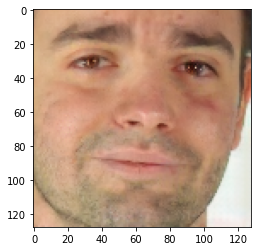

In [35]:
angle=np.pi
strength=0.6
mode='manual_selection'
expr=(torch.tensor([np.cos(angle),np.sin(angle)])*strength).to(device).float()
imgg=G_l2(img,None,None,mode=mode,manual_expr=expr)[0][0,[2,1,0],:,:]/2+0.5
imgg=imgg.transpose(0,2).transpose(0,1).detach().cpu().numpy()
imgplot = plt.imshow(imgg)

plt.show()

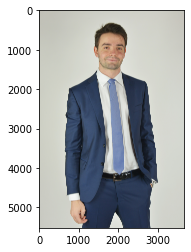

In [46]:
imgplot = plt.imshow(image[:,:,[2,1,0]])

In [50]:
plt.imsave('../real_me.jpg',image[:,:,[2,1,0]])

In [51]:
image_RGB=image[:,:,[2,1,0]]

In [52]:
image_RGB[y:y+h,x:x+w]=cv2.resize(imgg,(h,w))*255

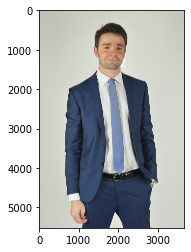

In [53]:
imgplot = plt.imshow(image_RGB)

In [55]:
plt.imsave('../fake_me.jpg',image_RGB)

In [43]:
cv2.resize(imgg,(666,666)).max()

0.97374296

In [13]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [16]:
frame_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
frame_gray = cv.equalizeHist(frame_gray)

In [15]:
import cv2 as cv

In [24]:
faces = faceCascade.detectMultiScale(frame_gray)

In [26]:
faces.shape

(5, 4)

In [27]:
for (x, y, w, h) in faces:
    cropped=cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

In [28]:
cropped.shape

(5520, 3680, 3)

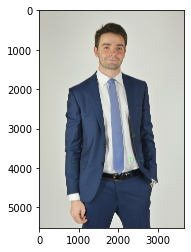

In [39]:
imgplot = plt.imshow(cropped[:,:,[2,1,0]])

In [36]:
cropped.shape

(5520, 3680, 3)

In [37]:
image.shape

(5520, 3680, 3)

In [20]:
cv2.imshow('hi',image)

In [21]:
cv2.waitKey()

-1